In [35]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor as dtr

from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

### Data Loading

In [2]:
conn = sqlite3.connect('RDS-2013-0009.4_SQLITE/Data/FPA_FOD_20170508.sqlite')

#conn = sqlite3.connect('FPA_FOD_20170508.sqlite')

In [4]:
# df = pd.read_sql_query("SELECT * FROM 'Fires'", conn)
# print(df.head())


In [5]:
print(df.columns)

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')


In [6]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR, STAT_CAUSE_CODE, LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_DOY,FIRE_SIZE,DISCOVERY_TIME, FIPS_CODE, CONT_DATE, OWNER_DESCR FROM 'Fires'", conn)
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
0       2005    Miscellaneous              9.0  40.036944 -121.005833    CA   
1       2004        Lightning              1.0  38.933056 -120.404444    CA   
2       2004   Debris Burning              5.0  38.984167 -120.735556    CA   
3       2004        Lightning              1.0  38.559167 -119.913333    CA   
4       2004        Lightning              1.0  38.559167 -119.933056    CA   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME FIPS_CODE  \
0       2453403.5             33       0.10           1300       063   
1       2453137.5            133       0.25           0845       061   
2       2453156.5            152       0.10           1921       017   
3       2453184.5            180       0.10           1600       003   
4       2453184.5            180       0.10           1600       003   

   CONT_DATE       OWNER_DESCR  
0  2453403.5              USFS  
1  2453137.5              

### Data Preprocessing and EDA

In [7]:
#Alter / Standardize few column
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
df['DISCOVERY_TIME'].fillna(pd.to_numeric(df['DISCOVERY_TIME'].dropna()).mean(), inplace=True)
df['CONT_TIME'] = df['CONT_DATE'] - df['DISCOVERY_DATE']
print(df.head())


   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
0       2005    Miscellaneous              9.0  40.036944 -121.005833    CA   
1       2004        Lightning              1.0  38.933056 -120.404444    CA   
2       2004   Debris Burning              5.0  38.984167 -120.735556    CA   
3       2004        Lightning              1.0  38.559167 -119.913333    CA   
4       2004        Lightning              1.0  38.559167 -119.933056    CA   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME FIPS_CODE  \
0       2453403.5             33       0.10           1300       063   
1       2453137.5            133       0.25           0845       061   
2       2453156.5            152       0.10           1921       017   
3       2453184.5            180       0.10           1600       003   
4       2453184.5            180       0.10           1600       003   

   CONT_DATE       OWNER_DESCR       DATE  MONTH DAY_OF_WEEK  CONT_TIME  
0  2453403.5      

In [9]:
#Dropping null values. Also, Combining state fips code to the original fips code.
df = df.dropna(subset=['FIPS_CODE'], axis=0)
df = df.dropna()


FIPS = {
    'NM': '35',
    'OR': '41',
    'WY': '56',
    'CA': '06',
    'CO': '08',
    'ID': '16',
    'MT': '30',
    'NV': '32',
    'AZ': '04',
    'UT': '49',
    'WA': '53',
}

df['STATEWISE_FIPS'] = df['STATE'].map(FIPS)
df['FIPS'] = df[['STATEWISE_FIPS', 'FIPS_CODE']].apply(''.join, axis=1)




In [10]:
#Drop not needed columns
df.drop(columns=['FIPS_CODE', 'STATEWISE_FIPS'], inplace=True)
df = df.drop('DISCOVERY_DATE',axis=1)
df = df.drop('CONT_DATE',axis=1)

In [11]:
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
0       2005    Miscellaneous              9.0  40.036944 -121.005833    CA   
1       2004        Lightning              1.0  38.933056 -120.404444    CA   
2       2004   Debris Burning              5.0  38.984167 -120.735556    CA   
3       2004        Lightning              1.0  38.559167 -119.913333    CA   
4       2004        Lightning              1.0  38.559167 -119.933056    CA   

   DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME       OWNER_DESCR       DATE  \
0             33       0.10           1300              USFS 2005-02-02   
1            133       0.25           0845              USFS 2004-05-12   
2            152       0.10           1921  STATE OR PRIVATE 2004-05-31   
3            180       0.10           1600              USFS 2004-06-28   
4            180       0.10           1600              USFS 2004-06-28   

   MONTH DAY_OF_WEEK  CONT_TIME   FIPS  
0      2   Wednesday        0.0  

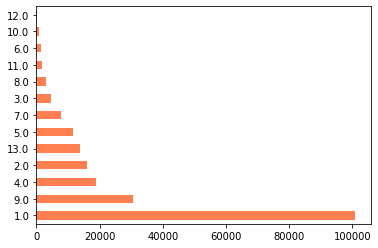

In [12]:
df['STAT_CAUSE_CODE'].value_counts().plot(kind='barh',color='coral')

plt.show()

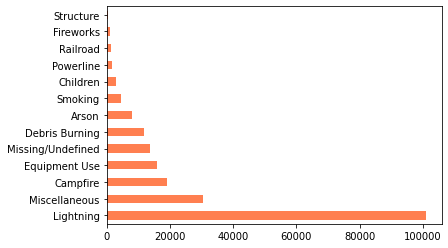

In [13]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

In [14]:
#Drop rows that have STAT_CAUSE_CODE ==9 || STAT_CUSE_DESCR == 13 because it represents Missing/Undefined, Miscellaneous.
df['STAT_CAUSE_CODE'] = df['STAT_CAUSE_CODE'].astype(int)
~((df['STAT_CAUSE_CODE'] == 13) | (df['STAT_CAUSE_CODE'] == 9))
df = df[~((df['STAT_CAUSE_CODE'] == 13) | (df['STAT_CAUSE_CODE'] == 9))]
print(df.head())





   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
1       2004        Lightning                1  38.933056 -120.404444    CA   
2       2004   Debris Burning                5  38.984167 -120.735556    CA   
3       2004        Lightning                1  38.559167 -119.913333    CA   
4       2004        Lightning                1  38.559167 -119.933056    CA   
5       2004        Lightning                1  38.635278 -120.103611    CA   

   DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME       OWNER_DESCR       DATE  \
1            133       0.25           0845              USFS 2004-05-12   
2            152       0.10           1921  STATE OR PRIVATE 2004-05-31   
3            180       0.10           1600              USFS 2004-06-28   
4            180       0.10           1600              USFS 2004-06-28   
5            182       0.10           1800              USFS 2004-06-30   

   MONTH DAY_OF_WEEK  CONT_TIME   FIPS  
1      5   Wednesday        0.0  

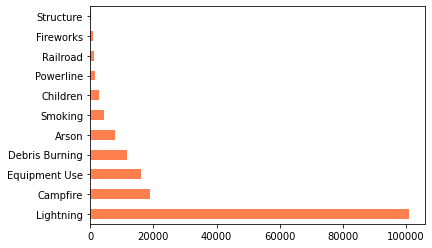

In [15]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

### Model Prep

In [16]:
#Scaling the values 
le = preprocessing.LabelEncoder()
df['STATE'] = le.fit_transform(df['STATE'])

df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['FIPS'] = le.fit_transform(df['FIPS'])
df['OWNER_DESCR'] = le.fit_transform(df['OWNER_DESCR'])
df = df.dropna()
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE  STATE  \
1       2004        Lightning                1  38.933056 -120.404444      1   
2       2004   Debris Burning                5  38.984167 -120.735556      1   
3       2004        Lightning                1  38.559167 -119.913333      1   
4       2004        Lightning                1  38.559167 -119.933056      1   
5       2004        Lightning                1  38.635278 -120.103611      1   

   DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME  OWNER_DESCR       DATE  MONTH  \
1            133       0.25           0845           14 2004-05-12      5   
2            152       0.10           1921           11 2004-05-31      5   
3            180       0.10           1600           14 2004-06-28      6   
4            180       0.10           1600           14 2004-06-28      6   
5            182       0.10           1800           14 2004-06-30      6   

   DAY_OF_WEEK  CONT_TIME  FIPS  
1            6        

In [17]:
#df = df.drop('STAT_CAUSE_DESCR',axis=1)


In [18]:
df = df.drop('DATE',axis=1)


In [19]:
df = df.drop('STAT_CAUSE_CODE',axis=1)
df_label = df
#Putting all the causes into 4 different categories, since there are so many of them. 
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    human = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning','Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in human:
        cause = 2
    else:
        cause = 3
    return cause

df_label['LABEL'] = df_label['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
df_drop_month_3 = df_label.drop('STAT_CAUSE_DESCR',axis=1)
print(df_drop_month_3.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DOY  FIRE_SIZE  \
1       2004  38.933056 -120.404444      1            133       0.25   
2       2004  38.984167 -120.735556      1            152       0.10   
3       2004  38.559167 -119.913333      1            180       0.10   
4       2004  38.559167 -119.933056      1            180       0.10   
5       2004  38.635278 -120.103611      1            182       0.10   

  DISCOVERY_TIME  OWNER_DESCR  MONTH  DAY_OF_WEEK  CONT_TIME  FIPS  LABEL  
1           0845           14      5            6        0.0    44      1  
2           1921           11      5            1        0.0    23      2  
3           1600           14      6            1        5.0    16      1  
4           1600           14      6            1        5.0    16      1  
5           1800           14      6            6        1.0    17      1  


In [20]:
y_label = df_drop_month_3['LABEL'].values
X_label = df_drop_month_3.drop(['LABEL'], axis=1).values
Xscaled = scale(X_label)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(Xscaled,y_label,test_size=0.20, random_state=0)

### KNN Classifier

In [21]:
KNC = KNeighborsClassifier(n_neighbors = 7)
KNC.fit(X_train_3, y_train_3)
print(KNC.score(X_train_3, y_train_3))
print(KNC.score(X_test_3, y_test_3))

0.8708128235673133
0.8388923851478918


### Decision Tree Classifier

In [22]:
model = tree.DecisionTreeClassifier(criterion = 'gini', 
                            max_depth = 200, 
                            min_samples_split = 100, 
                            min_samples_leaf = 10)
dt = model.fit(X_train_3, y_train_3)

In [23]:
# Print scores
print(f'Score on training set: {dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {dt.score(X_test_3, y_test_3)}')

Score on training set: 0.871022603822496
Score on testing set: 0.8507297192004555


### RandomForest Classifier

In [24]:

rf = RandomForestClassifier(n_estimators = 50, 
                            max_depth = 100, 
                            min_samples_split = 100, 
                            min_samples_leaf =40)

rf_dt = rf.fit(X_train_3, y_train_3)

print(f'Score on training set: {rf_dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {rf_dt.score(X_test_3, y_test_3)}')

Score on training set: 0.8684827643043912
Score on testing set: 0.8598699391650934


### Adaboost Classifier

In [25]:
ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth = 2), n_estimators = 30)
ada.fit(X_train_3, y_train_3)
ada.score(X_train_3, y_train_3)

0.8303027578611405

In [26]:
print(f'Score on training set: {ada.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {ada.score(X_test_3, y_test_3)}')

Score on training set: 0.8303027578611405
Score on testing set: 0.8319697923222152


### Logistic Regression

In [33]:
#  logistic regression model
lr = LogisticRegression(solver='lbfgs', 
                           penalty='l2', 
                           multi_class='multinomial', 
                           C=.9, 
                           max_iter=500, 
                           n_jobs=3)
lr_dt = lr.fit(X_train_3, y_train_3)

# Print scores
print(f'Score on training set: {lr_dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {lr_dt.score(X_test_3, y_test_3)}')


Score on training set: 0.6872775767383665
Score on testing set: 0.6865653750486979


### Decision Tree Regression

In [38]:
reg = dtr(random_state = 42)
reg_dt = reg.fit(X_train_3, y_train_3)


# Print scores
print(f'Score on training set: {reg_dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {reg_dt.score(X_test_3, y_test_3)}')


# y_pred = reg.predict(X_test)
# print(‘MSE =’, mse(y_pred, y_test))
# print(‘MAE =’, mae(y_pred, y_test))
# print(‘R2 Score =’, r2_score(y_pred, y_test))

Score on training set: 1.0
Score on testing set: 0.31086433060705987
